<h1><center>Module 15: Lesson 7 Feature engineering 1: From variables to features Assignment</center></h1>

## Assignment

In this assignment, you'll continue working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'studentsperformance'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?
2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

_________________________________________________________________________________________________________________

##### Import packages

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind
from scipy.stats import jarque_bera
from scipy.stats import boxcox
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

pd.set_option('display.max_columns', 500)

##### Grab data

In [81]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

studentsperformance_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [82]:
studentsperformance_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


_________________________________________________________________________________________________________________

##### Question 1

* Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

>To check for normal distribution we can use the Jarque-Bera test. If the pvalue is zero then we know that the variable is normally distributed.

In [57]:
jb_stats_math = jarque_bera(studentsperformance_df["math score"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats_math[0], jb_stats_math[1]))

Jarque-Bera test statistics is 15.912256686712709 and p value is 0.0003505075386818213


In [58]:
jb_stats_reading = jarque_bera(studentsperformance_df["reading score"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats_reading[0], jb_stats_reading[1]))

Jarque-Bera test statistics is 11.383300575987892 and p value is 0.0033740202672214448


In [59]:
jb_stats_writing = jarque_bera(studentsperformance_df["writing score"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats_writing[0], jb_stats_writing[1]))

Jarque-Bera test statistics is 13.98509448257235 and p value is 0.0009187033894586527


>pvalue is zero, which means that the distribution is statistically significantly different from a normal distribution. We can also check the distribution by visualizing it.

Text(0.5, 1.0, 'histogram of writing score')

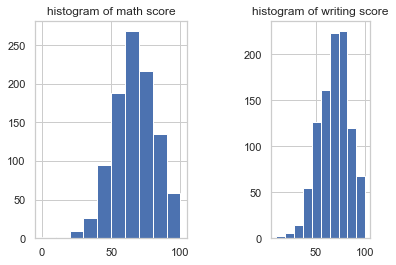

In [60]:
plt.subplot(1, 2, 1)
plt.hist(studentsperformance_df["math score"])
plt.title("histogram of math score")

plt.subplot(1, 2, 2)
plt.hist(studentsperformance_df["reading score"])
plt.title("histogram of reading score")

plt.subplot(1, 3, 3)
plt.hist(studentsperformance_df["writing score"])
plt.title("histogram of writing score")


>Now we need to apply a Box-Cox transformation in order to make the distribution normal.

In [106]:
#math must be made all positive in order to apply a Box-Cox
math_boxcox,_ = boxcox(studentsperformance_df[studentsperformance_df["math score"] > 0]["math score"])

In [107]:
jb_stats = jarque_bera(math_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))

Jarque-Bera test statistics is 1.7200982636836308 and p value is 0.42314129209599327


In [101]:
reading_boxcox,_ = boxcox(studentsperformance_df['reading score'])

jb_stats = jarque_bera(reading_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))

Jarque-Bera test statistics is 4.119778573559666 and p value is 0.127468081515408


In [102]:
writing_boxcox,_ = boxcox(studentsperformance_df['writing score'])

jb_stats = jarque_bera(writing_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))

Jarque-Bera test statistics is 4.746478090042761 and p value is 0.09317842784043195


##### Question 2

* Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

In [89]:
#create new column that is weighted average of previous three columns
studentsperformance_df['weighted average'] = ((studentsperformance_df['math score'] + 
                                              studentsperformance_df['reading score'] + 
                                              studentsperformance_df['writing score']) / 3).round(1)

In [90]:
studentsperformance_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,weighted average
0,female,group B,bachelor's degree,standard,none,72,72,74,72.7
1,female,group C,some college,standard,completed,69,90,88,82.3
2,female,group B,master's degree,standard,none,90,95,93,92.7
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.3
4,male,group C,some college,standard,none,76,78,75,76.3


In [91]:
#check if new variable is normally distributed
jb_stats_average = jarque_bera(studentsperformance_df["weighted average"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats_average[0], jb_stats_average[1]))

Jarque-Bera test statistics is 15.446782463470695 and p value is 0.0004423579191530358


>pvalue is zero, which means that the distribution is statistically significantly different from a normal distribution. Therefore we need to use a Box-Cox to normalize.

In [99]:
average_boxcox,_ = boxcox(studentsperformance_df['weighted average'])

In [100]:
jb_stats = jarque_bera(average_boxcox)
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))

Jarque-Bera test statistics is 2.4167301469095728 and p value is 0.2986852088334191


>pvalue is now greater than 0.05, we can therefore state that the distribution is statistically signifcantly different from a non-normal distribution.

##### Question 3

* Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In [108]:
corrmat_student = studentsperformance_df.corr()

In [109]:
corrmat_student

,math score,reading score,writing score,weighted average
math score,1.000000,0.817580,0.802642,0.918730
reading score,0.817580,1.000000,0.954598,0.970328
writing score,0.802642,0.954598,1.000000,0.965680
weighted average,0.918730,0.970328,0.965680,1.000000


>Reading and Writing scores have the highest degree of correlation with the overall weighted average score.